<a href="https://colab.research.google.com/github/marcellataleb/plane-classifier-project/blob/main/notebooks/generalized_train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importation de la base de données avec les images d'avions**

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  29.1M      0  0:01:30  0:01:30 --:--:-- 29.7M


**Lecture du fichier yaml avec les paramètres du modèle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yaml

with open('/content/drive/MyDrive/Projet - Hervé Mignot/generalized_yaml_file.yaml') as yaml_data:
  params = yaml.safe_load(yaml_data)
  
print(params)

{'image': {'height': 128, 'width': 128, 'depth': 3}, 'dir': {'model': '/content/drive/MyDrive/Projet - Hervé Mignot/model', 'data': 'dataset/data'}, 'target': 'family'}


### Imports

In [ ]:
import pathlib #permet de gérer proprement le chemin d'accès 

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf

from sklearn.model_selection import train_test_split

from PIL import Image

#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

## Constantes

In [ ]:
# Création des constantes 
IMAGE_HEIGHT = params['image']['height']
IMAGE_WIDTH = params['image']['width']
IMAGE_DEPTH = params['image']['depth']
TARGET_NAME = params['target']
MODEL_DIR = params['dir']['model']
DATA_DIR = pathlib.Path(params['dir']['data'])

In [ ]:
target_df = pd.read_csv(DATA_DIR /f"images_{TARGET_NAME}_train.txt" , sep=' ',
            names=['image_id', TARGET_NAME],
            usecols=['image_id', TARGET_NAME], # usecols for v1.4 compatibility
            dtype={'image_id': str},              # ids are not int but string
           )

In [ ]:
target_df = pd.read_csv(DATA_DIR / f"images_{TARGET_NAME}_train.txt", sep='\t',
            names=['all'],
            dtype={'all': str},              # ids are not int but string
           )

# La fonction split() découpe une chaîne de caractères
target_df['image_id'] = target_df['all'].apply(lambda x: x.split(' ')[0])

# La fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
target_df['TARGET_NAME'] = target_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

In [ ]:
target_array = target_df['TARGET_NAME'].unique()
target_array

array(['Boeing 707', 'Boeing 727', 'Boeing 737', 'Boeing 747',
       'Boeing 757', 'Boeing 767', 'Boeing 777', 'A300', 'A310', 'A320',
       'A330', 'A340', 'A380', 'ATR-42', 'ATR-72', 'An-12', 'BAE 146',
       'BAE-125', 'Beechcraft 1900', 'Boeing 717', 'C-130', 'C-47',
       'CRJ-200', 'CRJ-700', 'Cessna 172', 'Cessna 208',
       'Cessna Citation', 'Challenger 600', 'DC-10', 'DC-3', 'DC-6',
       'DC-8', 'DC-9', 'DH-82', 'DHC-1', 'DHC-6', 'Dash 8', 'DR-400',
       'Dornier 328', 'Embraer E-Jet', 'EMB-120', 'Embraer ERJ 145',
       'Embraer Legacy 600', 'Eurofighter Typhoon', 'F-16', 'F/A-18',
       'Falcon 2000', 'Falcon 900', 'Fokker 100', 'Fokker 50',
       'Fokker 70', 'Global Express', 'Gulfstream', 'Hawk T1', 'Il-76',
       'L-1011', 'MD-11', 'MD-80', 'MD-90', 'Metroliner', 'King Air',
       'PA-28', 'SR-20', 'Saab 2000', 'Saab 340', 'Spitfire', 'Tornado',
       'Tu-134', 'Tu-154', 'Yak-42'], dtype=object)

In [ ]:
target_list=target_array.tolist()

In [ ]:
# Si c'est égal à 0 pas de problème, sinon il donne un message d'erreur 
assert target_df['image_id'].isna().sum() == 0, "Valeur manquante dans image_id"
assert target_df['TARGET_NAME'].isna().sum() == 0, "Valeur manquante dans TARGET_NAME"

In [ ]:
target_df.head()

,all,image_id,TARGET_NAME
0,1025794 Boeing 707,1025794,Boeing 707
1,1340192 Boeing 707,1340192,Boeing 707
2,0056978 Boeing 707,0056978,Boeing 707
3,0698580 Boeing 707,0698580,Boeing 707
4,0450014 Boeing 707,0450014,Boeing 707


In [ ]:
target_df['path'] = target_df['image_id'].apply(lambda x: pathlib.Path(DATA_DIR / 'images') / (x + '.jpg'))

In [ ]:
target_df.head()

,all,image_id,TARGET_NAME,path
0,1025794 Boeing 707,1025794,Boeing 707,dataset/data/images/1025794.jpg
1,1340192 Boeing 707,1340192,Boeing 707,dataset/data/images/1340192.jpg
2,0056978 Boeing 707,0056978,Boeing 707,dataset/data/images/0056978.jpg
3,0698580 Boeing 707,0698580,Boeing 707,dataset/data/images/0698580.jpg
4,0450014 Boeing 707,0450014,Boeing 707,dataset/data/images/0450014.jpg


### Functions

In [ ]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images. 

  Parameters
  ---------
  path: path pattern to read csv file and images
  target (str): name of the target column 


  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',            
            names=['all'],  
            dtype={'all': str},                  
            ) 

  # la fonction split() découpe une chaîne de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image 
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))
  
  return _df.drop(columns=['all'])

In [ ]:
# La fonction : 
# - prend un df (argument)
# - prend une ligne (row: argument)
# - prend une colonne (target: argument)
# - elle affiche la classe (la valeur de target) et l'image associée pour la ligne en argument 

def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column 

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

In [ ]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width

  Returns 
  -------
  np.array containing resized image 

  """
  return np.array(Image.open(path).resize((width, height)))

In [ ]:
def build_classification_model(df: pd.DataFrame, target: str, images: str):
  """Build a TF model using information from target and images columns in dataframe. 

  Parameters
  ----------
  df (pd.DataFrame): dataframe with target and images columns
  target (str): column name for target variable 
  images (str): column name for images
  
  Returns
  -------
  TF model build & compiled
  """
  nb_classes = df[target].nunique() # Compute number of classes for output layer
  size = df[images].iloc[0].shape # Compute images size for input layer 
  
  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # Couche de sortie à nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str, stratify: str=None): # stratify est facultatif
  """Build x tensor and y tensor for model fittig. 
  
  Parameters
  ----------
  df(pd.DataFrame): dataframe containing images and target
  target (str): name of target column
  images (str): name of images column

  Returns
  -------
  x (np.array): tensor for x values 
  y (np.array): tensor for y values 
  """

  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y 

In [ ]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names: dictionary with names of classes

  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

In [ ]:
def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp. 

  Parameters
  ----------
  model(tf/Keras model): model to be saved
  basename: location to save model file
  """

  model.save(f'{MODEL_DIR}/{TARGET_NAME}.h5')
  return

### Load TARGET_NAME dataset

In [ ]:
target_df = build_image_database(DATA_DIR / f'images_{TARGET_NAME}_train.txt', 'TARGET_NAME')

Boeing 727


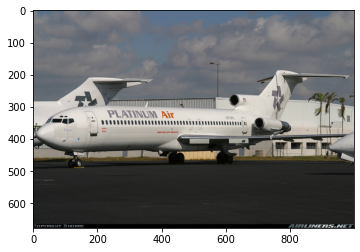

In [ ]:
show_image(target_df, 42, 'TARGET_NAME')

Boeing 707


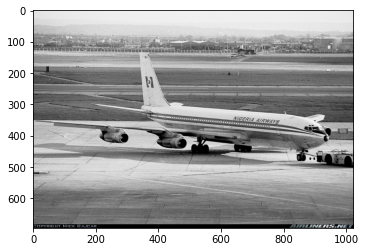

In [ ]:
show_image(build_image_database(DATA_DIR / f'images_{TARGET_NAME}_train.txt', 'family'), 24, 'family')

In [ ]:
target_df.shape

(3334, 3)

In [ ]:
target_df['shape'] = target_df['path'].apply(lambda p: plt.imread(p).shape)

In [ ]:
# Distribution du nombre de lignes
target_df['shape'].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: shape, Length: 404, dtype: int64

In [ ]:
# Distribution du nombre de colonnes
target_df['shape'].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: shape, Length: 73, dtype: int64

In [ ]:
target_df['resized_image'] = target_df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

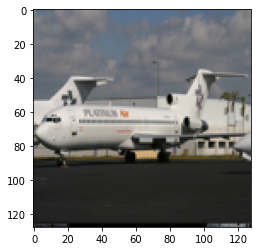

In [ ]:
plt.imshow(target_df.iloc[42,]['resized_image'])

## Build model

In [ ]:
model = build_classification_model(target_df, 'TARGET_NAME', 'resized_image')

In [ ]:
target_df['TARGET_NAME'].astype('category').cat.codes

0        4
1        4
2        4
3        4
4        4
        ..
3329    28
3330    28
3331    28
3332    28
3333    28
Length: 3334, dtype: int8

In [ ]:
y = tf.keras.utils.to_categorical(target_df['TARGET_NAME'].astype('category').cat.codes)

## Build train & test set

In [ ]:
# Load train & test dataset
train_df = build_image_database(DATA_DIR / f'images_{TARGET_NAME}_train.txt', 'TARGET_NAME')
test_df = build_image_database(DATA_DIR / f'images_{TARGET_NAME}_test.txt', 'TARGET_NAME')

# Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                           axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                         axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, 'TARGET_NAME', 'resized_image')
X_test, y_test = build_x_and_y(test_df, 'TARGET_NAME', 'resized_image')

# Build TF classification model
model = build_classification_model(train_df, 'TARGET_NAME', 'resized_image')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(target_df[['resized_image', 'TARGET_NAME']], y,
                                                    test_size=0.2,
                                                    stratify=target_df['TARGET_NAME'])

In [ ]:
assert X_train.shape[0] + X_test.shape[0] == target_df.shape[0] # la somme de train + test doit être égale au nombre de ligne d'entrée
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

In [ ]:
X_train['TARGET_NAME'].value_counts(normalize=True)[:5]

Boeing 737       0.080240
Boeing 747       0.039745
A340             0.039745
A320             0.039745
Embraer E-Jet    0.029996
Name: TARGET_NAME, dtype: float64

In [ ]:
X_test['TARGET_NAME'].value_counts(normalize=True)[:5]

Boeing 737    0.079460
A320          0.040480
Boeing 747    0.040480
A340          0.040480
Boeing 767    0.029985
Name: TARGET_NAME, dtype: float64

In [ ]:
print(X_train['resized_image'].shape, X_test['resized_image'].shape)

(2667,) (667,)


## Train model

In [ ]:
np.array(X_train['resized_image'].to_list()).shape

(2667, 128, 128, 3)

In [ ]:
%%time
epochs = 5
history = model.fit(np.array(X_train['resized_image'].to_list()), y_train, batch_size=32, epochs=epochs, 
                    validation_data=(np.array(X_test['resized_image'].to_list()), y_test))

Epoch 1/5
84/84 [==============================] - 327s 4s/step - loss: 11.9890 - accuracy: 0.0292 - val_loss: 4.2344 - val_accuracy: 0.0585
Epoch 2/5
84/84 [==============================] - 325s 4s/step - loss: 4.1978 - accuracy: 0.0469 - val_loss: 4.1473 - val_accuracy: 0.0570
Epoch 3/5
84/84 [==============================] - 329s 4s/step - loss: 4.1279 - accuracy: 0.0769 - val_loss: 4.1373 - val_accuracy: 0.0795
Epoch 4/5
84/84 [==============================] - 321s 4s/step - loss: 3.9986 - accuracy: 0.0821 - val_loss: 3.9707 - val_accuracy: 0.0825
Epoch 5/5
84/84 [==============================] - 327s 4s/step - loss: 3.8098 - accuracy: 0.0982 - val_loss: 3.8665 - val_accuracy: 0.1109
CPU times: user 51min 14s, sys: 27.2 s, total: 51min 41s
Wall time: 27min 22s


In [ ]:
%%time
epochs = 30
history = model.fit(np.array(X_train['resized_image'].to_list()), y_train, batch_size=96, epochs=epochs, 
                    validation_data=(np.array(X_test['resized_image'].to_list()), y_test))

Epoch 1/30
28/28 [==============================] - 329s 12s/step - loss: 70.4268 - accuracy: 0.1485 - val_loss: 3.0914 - val_accuracy: 0.2114
Epoch 2/30
28/28 [==============================] - 346s 12s/step - loss: 2.9988 - accuracy: 0.2006 - val_loss: 2.8822 - val_accuracy: 0.2294
Epoch 3/30
28/28 [==============================] - 328s 12s/step - loss: 2.8444 - accuracy: 0.2178 - val_loss: 2.8607 - val_accuracy: 0.2279
Epoch 4/30
28/28 [==============================] - 322s 12s/step - loss: 2.7302 - accuracy: 0.2317 - val_loss: 2.7364 - val_accuracy: 0.2309
Epoch 5/30
28/28 [==============================] - 356s 13s/step - loss: 2.6492 - accuracy: 0.2422 - val_loss: 2.7440 - val_accuracy: 0.2309
Epoch 6/30
28/28 [==============================] - 328s 12s/step - loss: 2.5420 - accuracy: 0.2621 - val_loss: 2.7018 - val_accuracy: 0.2279
Epoch 7/30
28/28 [==============================] - 328s 12s/step - loss: 2.4288 - accuracy: 0.2831 - val_loss: 2.6559 - val_accuracy: 0.2369
Epoch

In [ ]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.95.168.90:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.95.168.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.168.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Boeing 707


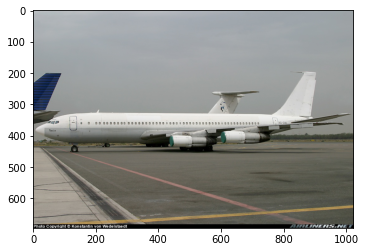

In [ ]:
show_image(test_df, 10, 'TARGET_NAME')

Boeing 707


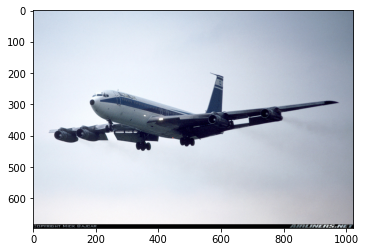

In [ ]:
show_image(train_df, 10, 'TARGET_NAME')

In [ ]:
X_train = np.array(X_train['resized_image'].to_list())

In [ ]:
X_test = np.array(X_test['resized_image'].to_list())

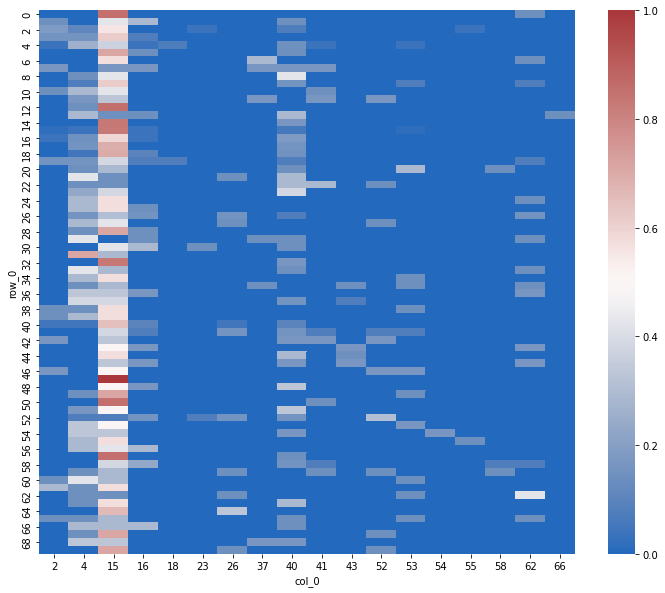

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_test, axis=1),
                        classify_images(X_test, model),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

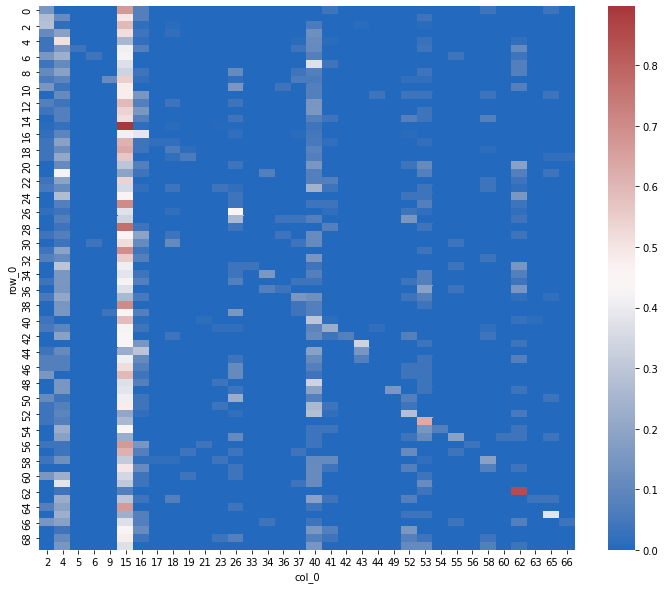

In [ ]:
# Heat map train set
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), classify_images(X_train, model), normalize='index'),
            cmap='vlag',
            ax=ax);

In [ ]:
save_model(model, MODEL_DIR)

In [ ]:
reloaded_model=load_model(f'/content/drive/MyDrive/Projet - Hervé Mignot/model/{TARGET_NAME}.h5')